In [1]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
# from paper_visualizations import * 
from PixelEM import * 
# from test_sample import test_sample_obj
import json

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [85]:
df = pd.read_csv("pixel_em/MV_PRJ_table.csv")
df = df.rename(columns={"MV_precision":"P [MV]",
                       "MV_recall":"R [MV]",
                       "MV_jaccard":"J [MV]"})
for mode in  ["GT","isoGT","GTLSA","isoGTLSA","basic"]:
    data =  pd.read_csv("pixel_em/{}_ground_truth_full_PRJ_table.csv".format(mode))
    data = data.rename(columns={"EM_precision":"P [{}]".format(mode),
                       "EM_recall":"R [{}]".format(mode),
                       "EM_jaccard":"J [{}]".format(mode),})
    df = df.merge(data)

In [86]:
metric_keys=[u'P [MV]',u'R [MV]', u'J [MV]', u'P [GT]', u'R [GT]', u'J [GT]', u'P [isoGT]',
       u'R [isoGT]', u'J [isoGT]', u'P [GTLSA]', u'R [GTLSA]', u'J [GTLSA]',
       u'P [isoGTLSA]', u'R [isoGTLSA]', u'J [isoGTLSA]', u'P [basic]',
       u'R [basic]', u'J [basic]']

#### Extracting important clusters only

In [87]:
metric_J= [u'J [MV]', u'J [GT]', u'J [isoGT]', u'J [GTLSA]', u'J [isoGTLSA]', u'J [basic]']
df["J [avrg]"]=df[metric_J].mean(axis=1)

filtered_algo_df = df[df["clust"].isin([0,-1])]

best_thres_clust = df.loc[df.groupby(['num_workers','sample_num','objid'])["J [avrg]"].idxmax()]

In [88]:
best_thres_clust.mean()[metric_keys]

P [MV]          0.946936
R [MV]          0.928896
J [MV]          0.882213
P [GT]          0.928893
R [GT]          0.969624
J [GT]          0.902690
P [isoGT]       0.961257
R [isoGT]       0.939234
J [isoGT]       0.904701
P [GTLSA]       0.964222
R [GTLSA]       0.930962
J [GTLSA]       0.900042
P [isoGTLSA]    0.967448
R [isoGTLSA]    0.932737
J [isoGTLSA]    0.904457
P [basic]       0.953215
R [basic]       0.948447
J [basic]       0.906506
dtype: float64

### Performance as it varies with number of workers

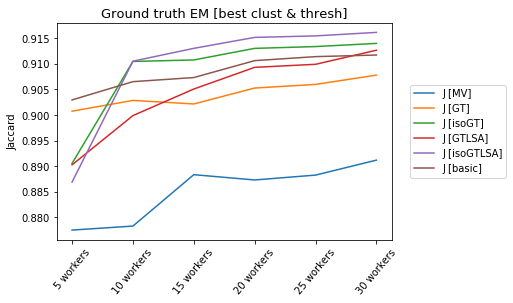

In [89]:
Nworker_performance = best_thres_clust.groupby("num_workers").mean()
MVarr = np.array(Nworker_performance["J [MV]"])
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in metric_J:
#    if '[GTLSA]' not in algo:#exclude GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best clust & thresh]",fontsize=13)

In [90]:
print "isoGTLSA_best_clust_thresh=",list(Nworker_performance['J [isoGTLSA]'])
print "isoGT_best_clust_thresh=",list(Nworker_performance['J [isoGT]'])
print "MV_best_clust_thresh=", list(Nworker_performance['J [MV]'])

isoGTLSA_best_clust_thresh= [0.88689167180043649, 0.91048138225685693, 0.91299126179100099, 0.91512888607542109, 0.91541973994201986, 0.91610285869121277]
isoGT_best_clust_thresh= [0.89053582642892704, 0.91043263143527653, 0.91072460538463296, 0.91298553956838557, 0.9133358038218542, 0.91395674303385022]
MV_best_clust_thresh= [0.8775262966952535, 0.87830363026608171, 0.88833647762838785, 0.88730470573821807, 0.88825327097293327, 0.89117292810808058]


In [11]:
def plot_PRcurve(objid,num_worker,sample_num=0):
    objdf = df[(df["num_workers"]==num_worker)&(df["sample_num"]==sample_num)&(df["objid"]==objid)]
    plt.figure()
    for algo in ['basic','GT','isoGT','GTLSA','isoGTLSA']:
        x= objdf["P [{}]".format(algo)]
        y = objdf["R [{}]".format(algo)]
        if len(x)<=0:
            return
        sortedx, sortedy = zip(*sorted(zip(x, y)))
        plt.plot(sortedx,sortedy,'.-',label=algo)
    plt.xlabel("Precision",fontsize=13)
    plt.ylabel("Recall",fontsize=13)
    plt.legend(loc="bottom left")
    plt.title("{}worker_rand{} [obj {};N={}]".format(num_worker,sample_num,objid,len(objdf)))

# Greedy Algo Results

In [125]:
from greedyPicking import *

In [126]:
from glob import glob 
import pandas as pd

globfnames = glob("withClust_greedy_result_*.csv")
globfnames.remove('withClust_greedy_result_worker_fraction.csv')
greedy_df = pd.read_csv(globfnames[0],index_col=0)
for fname in globfnames[1:]: 
    greedy_df = greedy_df.append(pd.read_csv(fname,index_col=0))

#assert len(greedy_df)==31*44*5

greedy_df.to_csv("withClust_all_greedy_result.csv")

In [127]:
greedy_df = pd.read_csv("withClust_all_greedy_result.csv",index_col=0)
ground_truth_greedy_df = pd.read_csv("ground_truth_greedy_result.csv")
ground_truth_greedy_df["cluster_id"] = -1
# greedy_df = greedy_df.append(ground_truth_greedy_df)

worker_frac_greedy_df = pd.read_csv("withClust_greedy_result_worker_fraction.csv")
noClust_worker_frac_greedy_df = pd.read_csv("greedy_old_results/greedy_result_worker_fraction.csv")
noClust_worker_frac_greedy_df["cluster_id"]=-1
# greedy_df = greedy_df.append(worker_frac_greedy_df)
greedy_df=pd.concat([greedy_df,ground_truth_greedy_df,worker_frac_greedy_df,noClust_worker_frac_greedy_df])
greedy_df["num_workers"] = greedy_df["sample"].apply(lambda x: int(x.split("workers")[0]))

In [128]:
noClust_greedy = pd.read_csv("greedy_old_results/all_greedy_result.csv",index_col=0)
noClust_greedy["cluster_id"]=-1
noClust_greedy["num_workers"] = noClust_greedy["sample"].apply(lambda x: int(x.split("workers")[0]))
greedy_df = pd.concat([greedy_df,noClust_greedy,])

In [129]:
# greedy_df.groupby(['sample','objid','cluster_id','algo']).mean()

In [130]:
best_thres_clust = greedy_df.loc[greedy_df.groupby(['sample','objid','cluster_id'])["j"].idxmax()]

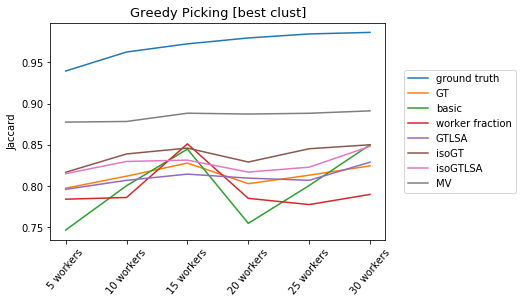

In [131]:
Nworker_performance = best_thres_clust.groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking [best clust]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [134]:
print "greedy_ground_truth=",list(Nworker_performance[Nworker_performance["algo"]=="ground truth"]['j'])
print "greedy_best_clust_isoGT_best_clust=",list(Nworker_performance[Nworker_performance["algo"]=="isoGT"]['j'])
print "greedy_best_clust_worker_frac_best_clust=",list(Nworker_performance[Nworker_performance["algo"]=="worker fraction"]['j'])

greedy_ground_truth= [0.93945579463386852, 0.96266602709650861, 0.97255700868926886, 0.97965396048192555, 0.98286834173734094, 0.9863217494865455]
greedy_best_clust_isoGT_best_clust= [0.89798084966980929, 0.90172692332783833, 0.90115935241699163, 0.91026799603210795, 0.90811380044456835, 0.91080227077649989]
greedy_best_clust_worker_frac_best_clust= [0.87059208586784431, 0.88653805811473196, 0.88572357142652258, 0.88768491119243764, 0.88774048826785179, 0.88989101610129528]


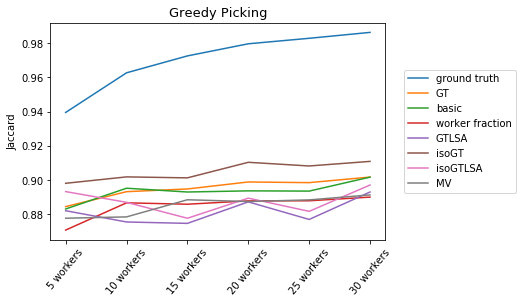

In [133]:
noClust_greedy_df = greedy_df[greedy_df["cluster_id"]==-1]

Nworker_performance = noClust_greedy_df.groupby(['algo','num_workers'],as_index=False)[['j']].mean()

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.plot(MVarr,label="MV")
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


### Compare between best thresh, best cluster thresh, no filtering

In [136]:
isoGT= [0.86180714318405227, 0.8988109346737535, 0.90404005468171478, 0.90954740011618374, 0.90776463234071514, 0.91052706488955748]
isoGT_best_thresh= [0.88030482691468614, 0.90370402275291195, 0.90762227879598867, 0.91135894959171038, 0.90901508399830366, 0.91165606774023689]
isoGT_best_clust_thresh= [0.89053582642892704, 0.91043263143527653, 0.91072460538463296, 0.91298553956838557, 0.9133358038218542, 0.91395674303385022]

isoGTLSA= [0.86001952128075243, 0.8852958258350111, 0.88859038520376588, 0.89840505843053553, 0.89202225166859883, 0.90219252902030678]
isoGTLSA_best_clust_thresh= [0.88689167180043649, 0.91048138225685693, 0.91299126179100099, 0.91512888607542109, 0.91541973994201986, 0.91610285869121277]
isoGTLSA_best_thresh= [0.87519051694562056, 0.8998780616894021, 0.90556915704845498, 0.9106581626726421, 0.90980669965364624, 0.911292941153929]

MV=[0.87752629669525561, 0.87830363026608183, 0.88833647762838908, 0.88730470573821674, 0.88825327097293416, 0.89117292810808058]

greedy_ground_truth= [0.93951474621942344, 0.96259939450243182, 0.97248527408043894, 0.97963366947487251, 0.98449873027478896, 0.98638885982213032]
greedy_best_clust_ground_truth= [0.93951474621942344, 0.96259939450243182, 0.97248527408043894, 0.97963366947487251, 0.98449873027478896, 0.98638885982213032]
greedy_best_clust_isoGT_best_clust= [0.81666471632318671, 0.83889938832313449, 0.84600792782630796, 0.82911366669473552, 0.84518859314462635, 0.85003625101149749]
greedy_best_clust_worker_frac_best_clust= [0.78398373054021864, 0.78606556755405699, 0.85113902106882366, 0.78499711065345612, 0.77747321106591438, 0.78978937616783218]
greedy_isoGT_no_clust= [0.89798084966980929, 0.90172692332783833, 0.90115935241699163, 0.91026799603210795, 0.90811380044456835, 0.91080227077649989]
greedy_worker_frac_no_clust= [0.87059208586784431, 0.88653805811473196, 0.88572357142652258, 0.88768491119243764, 0.88774048826785179, 0.88989101610129528]

In [145]:
algoDict=[{"val":isoGT,"name":'Best no clust, no thresh [isoGT]','color':"blue",'linestyle':"-."},
    {"val":isoGT_best_thresh,"name":'Best no clust, with thresh [isoGT]','color':"blue",'linestyle':"--"},
    {"val":isoGT_best_clust_thresh,"name":'Best with clust, with thresh [isoGT]','color':"blue",'linestyle':"-"},
          
    {"val":isoGTLSA,"name":'Best no clust, no thresh [isoGTLSA]','color':"red",'linestyle':"-."},
    {"val":isoGTLSA_best_thresh,"name":'Best no clust, with thresh [isoGTLSA]','color':"red",'linestyle':"--"},
    {"val":isoGTLSA_best_clust_thresh,"name":'Best with clust, with thresh [isoGTLSA]','color':"red",'linestyle':"-"},
          
    {"val":MV,"name":'MV','color':"gray",'linestyle':"-"},
]

#     
#]


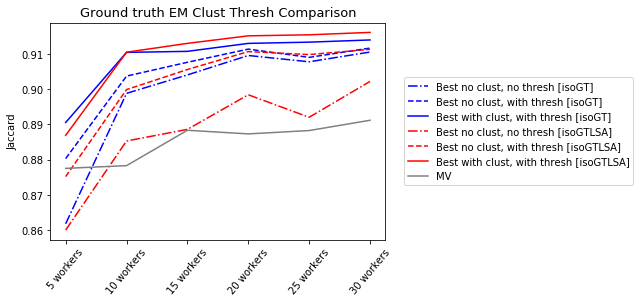

In [146]:
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in algoDict:
    plt.plot(algo["val"],label=algo["name"],color=algo["color"],linestyle=algo["linestyle"])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM Clust Thresh Comparison",fontsize=13)

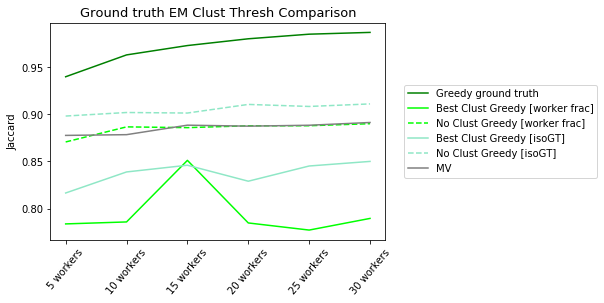

In [144]:
algoDict=[{"val":greedy_ground_truth,"name":'Greedy ground truth','color':"green",'linestyle':"-"},
    #neon green
    {"val":greedy_worker_frac_best_clust,"name":'Best Clust Greedy [worker frac]','color':"#00FF00",'linestyle':"-"},
    {"val":greedy_worker_frac_no_clust,"name":'No Clust Greedy [worker frac]','color':"#00FF00",'linestyle':"--"},

    {"val":greedy_isoGT_best_clust,"name":'Best Clust Greedy [isoGT]','color':"#8FE7C6",'linestyle':"-"},
    {"val":greedy_isoGT_no_clust,"name":'No Clust Greedy [isoGT]','color':"#8FE7C6",'linestyle':"--"},

    {"val":MV,"name":'MV','color':"gray",'linestyle':"-"},
]
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in algoDict:
    plt.plot(algo["val"],label=algo["name"],color=algo["color"],linestyle=algo["linestyle"])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM Clust Thresh Comparison",fontsize=13)

To do 
- pick MV only based on best workers
- Determine best cluster by heuristic of number of annotations in that cluster. 